读取数据集，在H.G.Wells的时光机器数据集上训练

In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

在train_iter中，每个词元都表示为一个数字索引， 将这些索引直接输入神经网络可能会使学习变得困难。 我们通常将每个词元表示为更具表现力的特征向量。 最简单的表示称为独热编码（one-hot encoding）

简言之，将每个索引映射为相互不同的单位向量： 假设词表中不同词元的数目为N（即len(vocab)）， 词元索引的范围为0到N-1。 <br>
如果词元的索引是整数i， 那么我们将创建一个长度为N的全0向量， 并将第i处的元素设置为1。 <br>
此向量是原始词元的一个独热向量。

例如对于索引为0和2，其独热向量如下

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的小批量数据形状是二维张量：（批量大小，时间步数）。 
one_hot函数将这样一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 
我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出。 
这将使我们能够更方便地通过最外层的维度， 一步一步地更新小批量数据的隐状态。

In [ ]:
# 创建一个包含0-9的张量
# 重塑为形状(2, 5)的二维张量
# 这模拟了一个小批量数据，其中:
# 批量大小 = 2 (两个序列样本)
# 序列长度/时间步数 = 5 (每个序列有5个词元)
X = torch.arange(10).reshape((2, 5))

# 将X进行转置
# 然后将每个元素转换为大小为28的独热向量
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

初始化模型参数

隐藏单元数num_hiddens是一个可调的超参数。 当训练语言模型时，输入和输出来自相同的词表。 
因此，它们具有相同的维度，即词表的大小。

In [ ]:
# 定义了一个获取RNN模型参数的函数
# 该函数接受词汇表大小、隐藏层单元数和设备作为输入
def get_params(vocab_size, num_hiddens, device):
    # 因为输入和输出都是词表中的词元因此维度相同
    # 将输入和输出的维度都设置为词表的大小
    num_inputs = num_outputs = vocab_size

    # 嵌套函数，用于创建指定形状的小随机值张量
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01  # 乘上0.01用于缩小值的范围

    # 隐藏层参数
    # W_xh: 输入到隐藏状态的权重矩阵(输入层→隐藏层)
    # W_hh: 隐藏状态到隐藏状态的权重矩阵(上一时间步隐藏层→当前时间步隐藏层)
    # b_h: 隐藏层的偏置项，初始化为零
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    # W_hq: 隐藏状态到输出的权重矩阵(隐藏层→输出层)
    # b_q: 输出层的偏置项，初始化为零
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    # 将所有参数放入一个列表，并且为每个参数启用梯度计算，这样这些参数就可以通过反向传播更新
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

返回元组而不是直接返回张量是为了保持接口一致性，因为在更复杂的RNN变体中(如LSTM)，隐藏状态可能包含多个张量。使用元组可以统一处理方式

In [ ]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。 此外，这里使用tanh函数作为激活函数

In [6]:
# inputs输入序列,形状为(时间步数量，批量大小，词表大小)
# state是隐藏状态,形状为(批量大小，隐藏单元数)
# params是模型参数
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params  # 解包参数列表得到五个模型参数

    # 逗号表示这是元组解包操作
    # 由于元组只包含一个元素，所以使用H,这种语法
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)

    # 循环处理每个时间步
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) # 更新隐藏状态
        Y = torch.mm(H, W_hq) + b_q # 计算当前时间步的输出
        outputs.append(Y) # 保存当前时间步的输出
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数，并存储从零开始实现的循环神经网络模型的参数

In [ ]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""

    # self: 实例自身的引用
    # vocab_size: 词汇表大小，决定输入和输出维度
    # num_hiddens: 隐藏层单元数
    # device: 计算设备(CPU或GPU)
    # get_params: 初始化模型参数的函数
    # init_state: 初始化隐藏状态的函数
    # forward_fn: 前向传播函数（这里是前面定义的rnn函数）
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    # 定义__call__方法，使类实例可以像函数一样被调用
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)  # 调用前向传播函数

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变。

输出形状应是（时间步数x批量大小，词表大小），而隐状态形状保持不变，即（批量大小，隐藏单元数）

In [ ]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())

# 这里就因为是创建了__call__使得可以像函数一样调用
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

预测

我们首先定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串。 在循环遍历prefix中的开始字符时，我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。这被称为预热（warm-up）期，因为在此期间模型会自我更新（例如，更新隐状态），但不会进行预测。 
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。

In [9]:
# num_preds是要预测的新字符数量
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    # 初始化隐藏状态
    state = net.begin_state(batch_size=1, device=device)

    # 初始化输出列表
    outputs = [vocab[prefix[0]]]

    # 输入获取函数
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))

    # 遍历前缀字符串中除第一个字符外的所有字符
    # net(get_input(), state): 使用当前输入和状态调用模型，得到输出和新状态
    # _, state =: 丢弃模型输出(用下划线表示)，只保留更新后的状态
    # outputs.append(vocab[y]): 将当前字符的索引添加到输出列表
    # 这个循环的目的是让隐藏状态"适应"前缀序列，但不使用模型的预测结果
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y]) # 将当前字符的索引添加到输出列表

    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    # 生成最终输出文本
    return ''.join([vocab.idx_to_token[i] for i in outputs])

现在我们可以测试predict_ch8函数。 我们将前缀指定为time traveller， 并基于这个前缀生成10个后续字符。 鉴于我们还没有训练网络，它会生成荒谬的预测结果。

In [10]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller xvdkscvitm'

梯度裁剪提供了一个快速修复梯度爆炸的方法，虽然它并不能完全解决问题，但它是众多有效的技术之一。

通过梯度裁剪能够带来以下几方面的好处：
- 训练稳定性提高：防止模型因单次过大的梯度更新而偏离优化方向。
- 防止梯度爆炸：特别是在RNN训练中，对长序列依赖的建模非常有效。
- 不影响收敛方向：只修改梯度的大小而不改变方向，保持优化的总体方向。

In [15]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) # 所有模型参数的梯度的范数
    # 超过阈值，则按比例进行缩小
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型。<br>
它与我们训练 3.6节模型的方式有三个不同之处。
- 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
- 我们在更新模型参数之前裁剪梯度。 这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
- 我们用困惑度来评价模型。这样的度量确保了不同长度的序列具有可比性。

困惑度：Perplexity = exp(损失)  其中损失通常是交叉熵损失<br>
在RNN语言模型中，困惑度计算方式为：<br>
PPL = exp(-(1/N) * Σ log P(x_t|x_1, ..., x_{t-1}))<br>
困惑度可以被直观理解为平均分支因子，在每一步，模型平均需要考虑多少种可能性才能做出正确预测

相比直接使用损失值，困惑度有以下优势：
- 可比性：困惑度可以公平比较不同长度的序列，因为它对序列长度进行了标准化
- 可解释性：困惑度有明确的直观解释，例如困惑度为10意味着模型在每一步预测时平均"困惑"于10个等可能的选择
- 尺度一致性：不同数据集和模型之间的困惑度可以直接比较，而交叉熵损失则可能依赖于词汇表大小
- 历史继承：作为评估语言模型的传统指标，使用困惑度便于与历史研究进行比较

具体来说，当使用顺序分区时，我们只在每个迭代周期的开始位置初始化隐状态。 <br>
由于下一个小批量数据中的第i个子序列样本与当前第i个子序列样本相邻，因此当前小批量数据最后一个样本的隐状态,将用于初始化下一个小批量数据第一个样本的隐状态。这样，存储在隐状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列。<br>
然而，在任何一点隐状态的计算，都依赖于同一迭代周期中前面所有的小批量数据，这使得梯度计算变得复杂。<br>
为了降低计算量，在处理任何一个小批量数据之前，我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，因此需要为每个迭代周期重新初始化隐状态。<br>
与 3.6节中的 train_epoch_ch3函数相同，updater是更新模型参数的常用函数。<br>
它既可以是从头开始实现的d2l.sgd函数，也可以是深度学习框架中内置的优化函数。

In [11]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量

    # 小批量数据迭代
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 若非首次迭代且使用顺序抽样，需要分离隐藏状态的梯度计算
            # 根据模型类型不同采用不同的处理方式：
            # 如果是PyTorch内置的nn.Module且状态不是元组(如nn.GRU的情况)：直接对状态调用detach_()
            # 否则(如nn.LSTM或自定义RNN，状态是元组)：遍历元组中的每个张量并调用detach_()
            # detach_()的目的：切断梯度计算图，使得隐藏状态的梯度计算仅限于当前小批量内
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        # 处理目标张量
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) # 以阈值1裁剪梯度，防止梯度爆炸
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

训练循环神经网络模型 

因为我们在数据集中只使用了10000个词元，所以模型需要更多的迭代周期来更好地收敛

困惑度 1.0, 77215.6 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


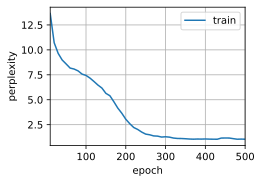

In [16]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

与随机抽样方法进行对比

困惑度 1.4, 84260.9 词元/秒 cuda:0
time travellerit s against reason said filbycan a cube that does
travellerit s against reason said filbycan a cube that does


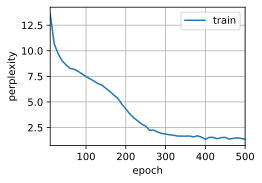

In [17]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。

一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。

循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。

当使用顺序划分时，我们需要分离梯度以减少计算量。

在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐状态）。

梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。